## Instalação e import das bibliotecas necessárias

In [12]:
!pip install -U -q PyDrive
! pip install vaderSentiment

     |████████████████████████████████| 133kB 2.9MB/s 


In [13]:
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from string import punctuation
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import da biblioteca para conexão com o Google Drive

In [4]:
from google.colab import drive
# função para conectar com o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregando o Dataset

In [5]:
df_fake = pd.read_csv('/content/drive/My Drive/Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_true = pd.read_csv('/content/drive/My Drive/True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Preprocessamento e Visualização

In [7]:
# Criando uma nova coluna 'categoria', para identificar true e fake news no dataframe
df_true['categoria'] = 1
df_fake['categoria'] = 0

In [8]:
# Concatenando os datasets true e fake
df = pd.concat([df_true, df_fake])

In [17]:
# utilizando a biblioteca Plotly para visualização temporal das noticias
distribuiton = go.Figure(layout = go.Layout(title = 'Variação da quantidade de noticias', yaxis_title = 'Número de notícias', xaxis_title = 'Data'))
distribuiton.add_trace(go.Scatter(y = df[df.categoria == 0].groupby(['date']).categoria.count(), 
                                  mode = 'lines',
                                  name = 'true'))
distribuiton.add_trace(go.Scatter(x = df[df.categoria == 1].groupby(['date']).categoria.count().index, y = df[df.categoria == 1].groupby(['date']).categoria.count(),
                                  mode = 'lines',
                                  name = 'fake'))
distribuiton.show()

Text(0.5, 1.0, 'Fake x True News')

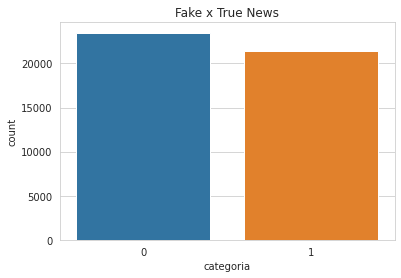

In [16]:
# Plot da quantidade de noticias fake e true
sns.set_style("whitegrid")
sns.countplot(df.categoria)
plt.title('Fake x True News')

In [17]:
df.head()

,title,text,subject,date,categoria
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [18]:
# verificando a quantidade de temas
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

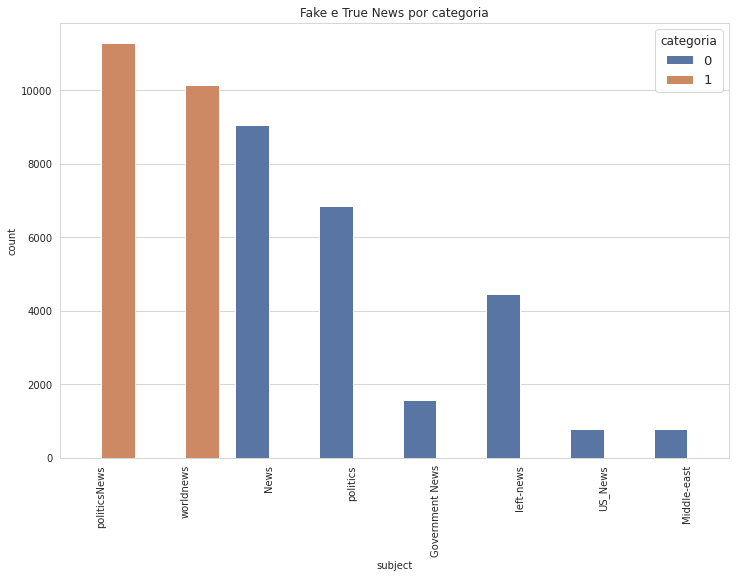

In [19]:
# plot da quantidade de noticias por temas
plt.figure(figsize = (12,8))
plt.title('Fake e True News por categoria')
sns.set(style = 'whitegrid', font_scale = 1.2)
chart = sns.countplot(x = 'subject', hue = 'categoria', data = df)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)

In [20]:
df['text'] = df['text'] + ' ' + df['title']
del df['title']
del df['subject']
del df['date']

In [20]:
# criando os objetos para preparar remoção de pontuação e stopwords
english_stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
english_stops.update(punctuation)

In [21]:
# para conhecimento das stopwords em Inglês
print(english_stops)

{'weren', 'here', 'having', '-', 'while', "wouldn't", 'few', '[', '?', 'through', 'mightn', '|', 'your', 'wouldn', 'itself', 'which', 'she', "hadn't", 'does', "don't", '{', 'he', "shouldn't", 'wasn', 'not', "it's", 'can', 'when', "she's", "should've", 'our', '@', 'of', '>', "'", 'you', 'an', 'under', 'below', 'had', 'hadn', 'to', 'just', 'myself', '.', 'herself', '*', '}', '~', "you've", 'its', "that'll", '`', 'further', 'will', 're', 'hasn', 'no', 'theirs', 'couldn', "mightn't", ',', '/', 'ourselves', 'nor', "you'll", 'their', 'doesn', '"', 'so', 'during', "shan't", 'these', 'into', 'above', ':', 'they', 'on', 'been', 'themselves', 'there', 'against', "isn't", 'didn', 'this', 'being', 'now', 'haven', 'shouldn', '\\', 'him', 'both', "aren't", '<', 'more', 'doing', "mustn't", 'as', 'too', 'o', "weren't", 'ours', 'but', 'off', "won't", 'whom', "needn't", 'by', 's', 'other', 've', '^', 'between', 'and', 'over', 'y', 'aren', "doesn't", 'very', 'them', '(', 'was', 'have', 'same', 'than', 'y

In [22]:
#criando uma função para remoção de stopwords e transformando em string
def remove_stopwords(text):
  new_text = []
  for i in text.split():
    if i.strip().lower() not in english_stops:
      new_text.append(i.strip())
  return " ".join(new_text)

# aplicar a remoção de stop word no texto "text"
def preprocessed_text(text):
  text = remove_stopwords(text)
  return text

df['text'] = df['text'].apply(preprocessed_text)

## Visualização com Word Cloud das palavras mais comuns

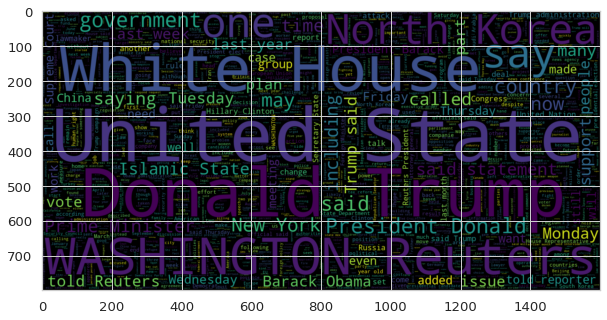

In [26]:
# wordcloud para o texto true news, categoria = 1
plt.figure(figsize = (10, 10))
word_cloud = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS). generate(" ".join(df[df.categoria == 1].text))
plt.imshow(word_cloud, interpolation = 'bilinear')

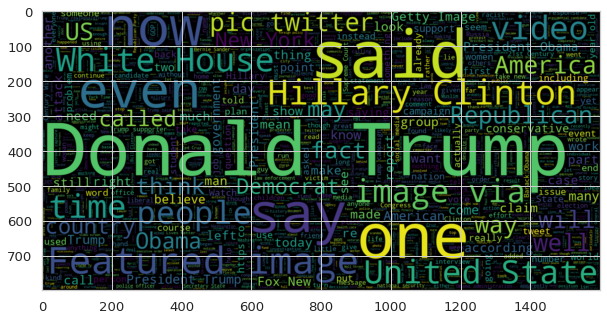

In [27]:
# wordcloud para o texto fake news, categoria = 0
plt.figure(figsize = (10, 10))
word_cloud = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS). generate(" ".join(df[df.categoria == 0].text))
plt.imshow(word_cloud, interpolation = 'bilinear')

In [44]:
# aplicação do Counter para contar quantidade de vezes que a palavra aparece
counter = Counter(corpus)
most_common = counter.most_common(8)
most_common = dict(most_common)

# sorted para imprimir o dicionario em ordem decrescente
sorted_dict = dict( sorted (most_common.items(),
                            key = lambda item: item[1],
                            reverse = True))

# for para imprimir o dicionario vertical
for key, value in sorted_dict.items():
  print(key, ' : ', value)

Trump  :  111503
said  :  93162
would  :  54613
U.S.  :  50441
President  :  33180
people  :  33115
also  :  30325
one  :  29370


## Bigram para verificação de frequência de duas palavras aparecerem juntas

In [49]:
# função para aplicar bigram
def get_bigrams(corpus, n, g):
  vec = CountVectorizer(ngram_range = (g, g)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
  return words_freq[:n]

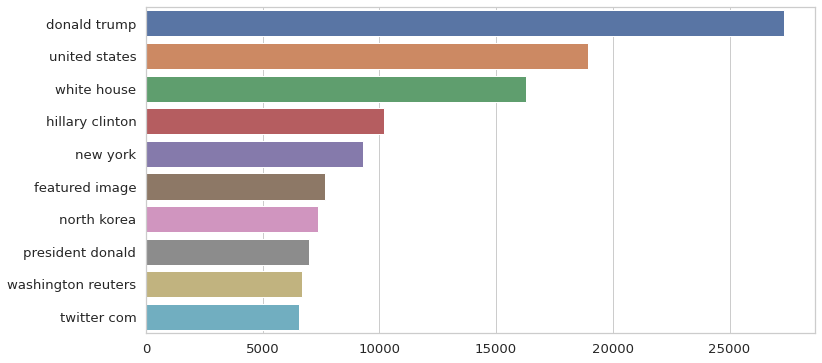

In [51]:
# plot do barplot com a biblioteca Seaborn
plt.figure(figsize = (12, 6))
bigram = get_bigrams(df.text, 10, 2)
bigram = dict(bigram)
sns.barplot(x = list(bigram.values()), y = list(bigram.keys()))

## Analise da quantidade de caracteres para buscar padrões entre true e fake news

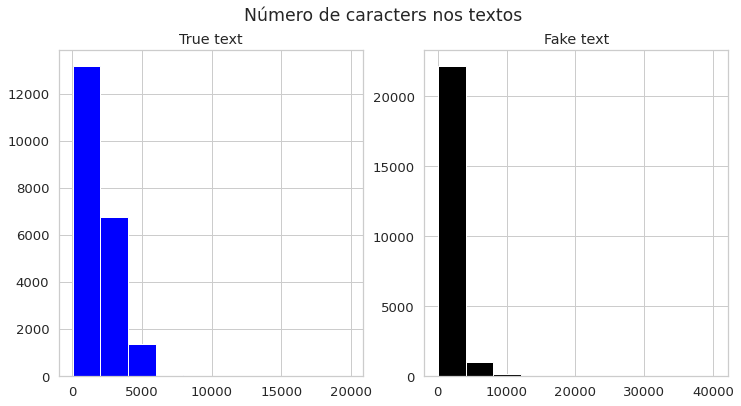

In [55]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 6))
text_len = df[df['categoria'] == 1]['text'].str.len()
ax1.hist(text_len, color = 'blue')
ax1.set_title('True text')
text_len = df[df['categoria'] == 0]['text'].str.len()
ax2.hist(text_len, color = 'black')
ax2.set_title('Fake text')
fig.suptitle('Número de caracters nos textos')
plt.show()

## Aplicação de análise de sentimentos com a biblioteca Vader

In [71]:
# criando um objeto e palicando iloc para guardar o valor do texto
text_sentiment = df.loc[0, "text"]

In [73]:
# aplicando o método Vader para analise de sentimentos no texto
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(text_sentiment)

{'compound': 0.9907, 'neg': 0.13, 'neu': 0.694, 'pos': 0.175}